# 빅데이터 분석 mini project
#### python 2 기반

In [1]:
import os
import sys 
os.path.expanduser("~")
os.environ["SPARK_HOME"]=os.path.join(os.path.expanduser("~"),'Downloads','spark-2.0.0-bin-hadoop2.7')
os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.1-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config('spark.sql.warehouse.dir','file:///C:/Users/user')\
    .getOrCreate()
spark.conf.get('spark.sql.warehouse.dir')

u'file:///C:/Users/user'

-----------

### txt 파일 불러와서 Df 생성

In [2]:
mRdd=spark.sparkContext\
    .textFile(os.path.join("data","melon_weekly2019~2013.txt"))
print (mRdd.first())

2019//01월//12.31~01.06//  1//180도//벤//0//순위 동일


In [3]:
mRdd1=mRdd.map(lambda x: x.split('//'))

In [4]:
from pyspark.sql import Row
mRdd=mRdd1.map(lambda x:Row(int(x[0]),int(x[1].lstrip().rstrip(u'\uc6d4')),x[2].lstrip(),int(x[3]),x[4].lstrip(),x[5].lstrip(),int(x[6].lstrip()),x[7].lstrip()))
mDf=spark.createDataFrame(mRdd) 
mDf.printSchema()
mDf.show(5)

root
 |-- _1: long (nullable = true)
 |-- _2: long (nullable = true)
 |-- _3: string (nullable = true)
 |-- _4: long (nullable = true)
 |-- _5: string (nullable = true)
 |-- _6: string (nullable = true)
 |-- _7: long (nullable = true)
 |-- _8: string (nullable = true)

+----+---+-----------+---+----+-----------+---+-----+
|  _1| _2|         _3| _4|  _5|         _6| _7|   _8|
+----+---+-----------+---+----+-----------+---+-----+
|2019|  1|12.31~01.06|  1|180도|          벤|  0|순위 동일|
|2019|  1|12.31~01.06|  2|넘쳐흘러|      엠씨더맥스|  0|  NEW|
|2019|  1|12.31~01.06|  3| 신용재|         하은|  3|단계 상승|
|2019|  1|12.31~01.06|  4|SOLO|제니 (JENNIE)|  0|순위 동일|
|2019|  1|12.31~01.06|  5| 아낙네| MINO (송민호)|  3|단계 하락|
+----+---+-----------+---+----+-----------+---+-----+
only showing top 5 rows



In [5]:
mDf=mDf.withColumn("Year",mDf['_1'].cast("long")).drop('_1')
mDf=mDf.withColumn("Month",mDf['_2'].cast("integer")).drop('_2')
mDf=mDf.withColumn("Week",mDf['_3'].cast("string")).drop('_3')
mDf=mDf.withColumn("Rank",mDf['_4'].cast("integer")).drop('_4')
mDf=mDf.withColumn("Title",mDf['_5'].cast("string")).drop('_5')
mDf=mDf.withColumn("Artist",mDf['_6'].cast("string")).drop('_6')
mDf=mDf.withColumn("Changed_rank",mDf['_7'].cast("Integer")).drop('_7')
mDf=mDf.withColumn("State",mDf['_8'].cast("string")).drop('_8')

In [6]:
mDf.show()

+----+-----+-----------+----+--------------------+------------+------------+-----+
|Year|Month|       Week|Rank|               Title|      Artist|Changed_rank|State|
+----+-----+-----------+----+--------------------+------------+------------+-----+
|2019|    1|12.31~01.06|   1|                180도|           벤|           0|순위 동일|
|2019|    1|12.31~01.06|   2|                넘쳐흘러|       엠씨더맥스|           0|  NEW|
|2019|    1|12.31~01.06|   3|                 신용재|          하은|           3|단계 상승|
|2019|    1|12.31~01.06|   4|                SOLO| 제니 (JENNIE)|           0|순위 동일|
|2019|    1|12.31~01.06|   5|                 아낙네|  MINO (송민호)|           3|단계 하락|
|2019|    1|12.31~01.06|   6|            MILLIONS|      WINNER|           3|단계 하락|
|2019|    1|12.31~01.06|   7|              벌써 12시|          청하|           0|  NEW|
|2019|    1|12.31~01.06|   8|               너를 만나|          폴킴|           3|단계 하락|
|2019|    1|12.31~01.06|   9|          YES or YES|TWICE (트와이스)|           2|단계 하락|
|201

### 생성한 df 바탕으로 분석에 필요한 순위 변동추이 계산하여 행 만들기

In [7]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
def classifyState(s,c,r):
    q=0
    if s==u"단계 하락":
        q=c*(-1)
    elif s==u"단계 상승":
        q=c
    elif s=="NEW":
        q=100-r
    elif s==u"순위 동일":
        q=0
    return q

state_udf = udf(classifyState, StringType())

In [8]:
mDf2=mDf.withColumn("Rank_variation", state_udf(mDf.State,mDf.Changed_rank,mDf.Rank))
mDf2.show()
mDf2.write.format('com.databricks.spark.csv').save(os.path.join('data','MelonWeekly.csv'))

+----+-----+-----------+----+--------------------+------------+------------+-----+--------------+
|Year|Month|       Week|Rank|               Title|      Artist|Changed_rank|State|Rank_variation|
+----+-----+-----------+----+--------------------+------------+------------+-----+--------------+
|2019|    1|12.31~01.06|   1|                180도|           벤|           0|순위 동일|             0|
|2019|    1|12.31~01.06|   2|                넘쳐흘러|       엠씨더맥스|           0|  NEW|            98|
|2019|    1|12.31~01.06|   3|                 신용재|          하은|           3|단계 상승|             3|
|2019|    1|12.31~01.06|   4|                SOLO| 제니 (JENNIE)|           0|순위 동일|             0|
|2019|    1|12.31~01.06|   5|                 아낙네|  MINO (송민호)|           3|단계 하락|            -3|
|2019|    1|12.31~01.06|   6|            MILLIONS|      WINNER|           3|단계 하락|            -3|
|2019|    1|12.31~01.06|   7|              벌써 12시|          청하|           0|  NEW|            93|
|2019|    1|12.31~01

AnalysisException: u'path file:/C:/Users/user/data/MelonWeekly.csv already exists.;'

In [12]:
mDf3=mDf2.groupBy('Month').agg({"Rank_variation":"sum"}).sort('Month')
mDf3.show()
mDf3.printSchema()

+-----+-------------------+
|Month|sum(Rank_variation)|
+-----+-------------------+
|    1|             3954.0|
|    2|             3151.0|
|    3|             4227.0|
|    4|             3922.0|
|    5|             3631.0|
|    6|             3396.0|
|    7|             3642.0|
|    8|             3396.0|
|    9|             3625.0|
|   10|             5417.0|
|   11|             4666.0|
|   12|             4400.0|
+-----+-------------------+

root
 |-- Month: integer (nullable = true)
 |-- sum(Rank_variation): double (nullable = true)



In [14]:
import pandas as pd
mDf4=mDf2.groupBy('Year').pivot('Month').agg({"Rank_variation":"sum"}).sort('Year')
mDf4.show()
pdf=mDf4.toPandas()
pdf.head()

+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+------+
|Year|    1|    2|    3|    4|    5|    6|    7|    8|    9|    10|   11|    12|
+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+------+
|2013|991.0|938.0|989.0|892.0|906.0|743.0|757.0|820.0|754.0|1202.0|857.0| 977.0|
|2014|932.0|792.0|693.0|796.0|888.0|645.0|871.0|677.0|552.0|1309.0|979.0| 538.0|
|2015|819.0|427.0|608.0|742.0|495.0|680.0|851.0|523.0|589.0| 794.0|686.0|1545.0|
|2016|475.0|371.0|745.0|588.0|627.0|754.0|612.0|415.0|820.0| 847.0|559.0| 830.0|
|2017|290.0|287.0|319.0|238.0|232.0|339.0|169.0|279.0|384.0| 342.0|568.0| 323.0|
|2018|146.0|192.0|437.0|322.0|260.0|137.0|146.0|382.0|178.0| 380.0|663.0| 187.0|
|2019|301.0|144.0|436.0|344.0|223.0| 98.0|236.0|300.0|348.0| 543.0|354.0|  null|
+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+------+



,Year,1,2,3,4,5,6,7,8,9,10,11,12
0,2013,991.0,938.0,989.0,892.0,906.0,743.0,757.0,820.0,754.0,1202.0,857.0,977.0
1,2014,932.0,792.0,693.0,796.0,888.0,645.0,871.0,677.0,552.0,1309.0,979.0,538.0
2,2015,819.0,427.0,608.0,742.0,495.0,680.0,851.0,523.0,589.0,794.0,686.0,1545.0
3,2016,475.0,371.0,745.0,588.0,627.0,754.0,612.0,415.0,820.0,847.0,559.0,830.0
4,2017,290.0,287.0,319.0,238.0,232.0,339.0,169.0,279.0,384.0,342.0,568.0,323.0


### 그래프 그리기

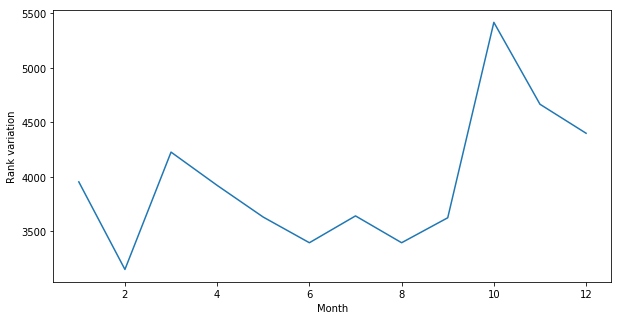

<Figure size 720x720 with 0 Axes>

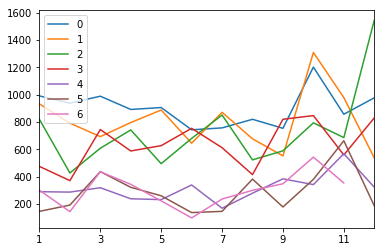

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#월별 순위변동추이 그래프

X3=mDf3.select("Month").collect()
Y3=mDf3.select("sum(Rank_variation)").collect()

plt.figure(figsize=(10,5))
plt.plot(X3,Y3)
plt.xlabel("Month")
plt.ylabel("Rank variation")
plt.show()

mDf4_gr=pdf.drop('Year',1).transpose()
mDf4_gr.plot(kind='line')


### Regression Analysis

[Row(Year=2013), Row(Year=2014), Row(Year=2015), Row(Year=2016), Row(Year=2017), Row(Year=2018), Row(Year=2019)]
[[Row(1=991.0), Row(1=932.0), Row(1=819.0), Row(1=475.0), Row(1=290.0), Row(1=146.0), Row(1=301.0)]]


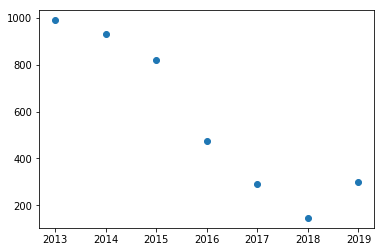

[[Row(2=938.0), Row(2=792.0), Row(2=427.0), Row(2=371.0), Row(2=287.0), Row(2=192.0), Row(2=144.0)]]


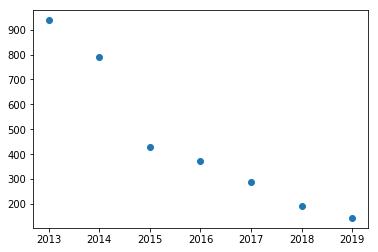

[[Row(3=989.0), Row(3=693.0), Row(3=608.0), Row(3=745.0), Row(3=319.0), Row(3=437.0), Row(3=436.0)]]


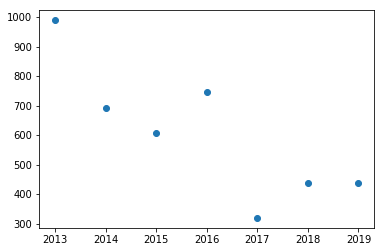

[[Row(4=892.0), Row(4=796.0), Row(4=742.0), Row(4=588.0), Row(4=238.0), Row(4=322.0), Row(4=344.0)]]


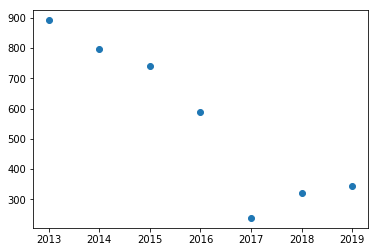

[[Row(5=906.0), Row(5=888.0), Row(5=495.0), Row(5=627.0), Row(5=232.0), Row(5=260.0), Row(5=223.0)]]


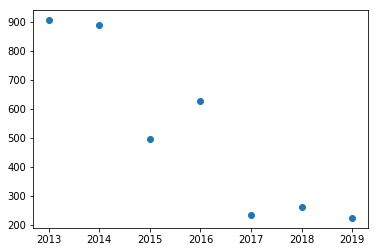

[[Row(6=743.0), Row(6=645.0), Row(6=680.0), Row(6=754.0), Row(6=339.0), Row(6=137.0), Row(6=98.0)]]


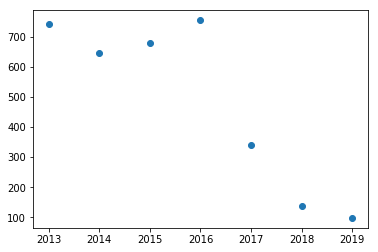

[[Row(7=757.0), Row(7=871.0), Row(7=851.0), Row(7=612.0), Row(7=169.0), Row(7=146.0), Row(7=236.0)]]


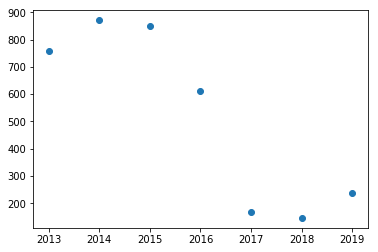

[[Row(8=820.0), Row(8=677.0), Row(8=523.0), Row(8=415.0), Row(8=279.0), Row(8=382.0), Row(8=300.0)]]


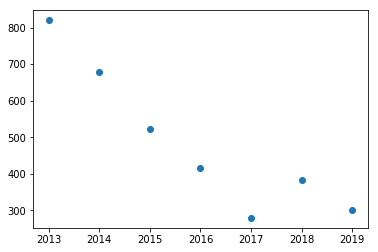

[[Row(9=754.0), Row(9=552.0), Row(9=589.0), Row(9=820.0), Row(9=384.0), Row(9=178.0), Row(9=348.0)]]


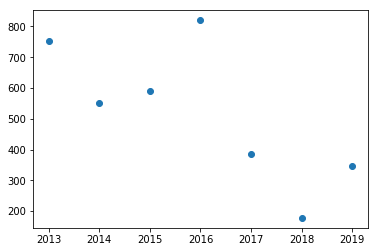

[[Row(10=1202.0), Row(10=1309.0), Row(10=794.0), Row(10=847.0), Row(10=342.0), Row(10=380.0), Row(10=543.0)]]


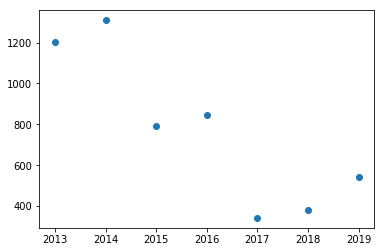

[[Row(11=857.0), Row(11=979.0), Row(11=686.0), Row(11=559.0), Row(11=568.0), Row(11=663.0), Row(11=354.0)]]


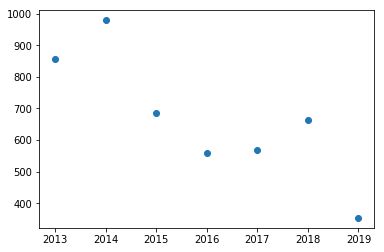

[[Row(12=977.0), Row(12=538.0), Row(12=1545.0), Row(12=830.0), Row(12=323.0), Row(12=187.0), Row(12=None)]]


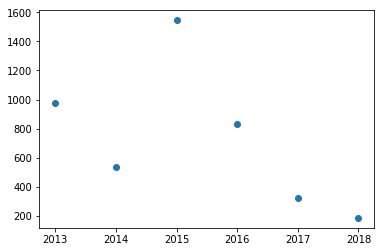

In [23]:
#1월부터 12월까지, 매년 순위변동추이의 값의 변화를 scatter plot으로 확인, X축은 연도 Y축은 순위변동정도

X=mDf4.select('Year').collect()
Y=list()

print (X)
for i in range(1,13):  
    Y.append([mDf4.select(str(i)).collect()])
    print(Y[i-1])
    plt.scatter(X,Y[i-1])
    plt.show()


1


C:\Users\user\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


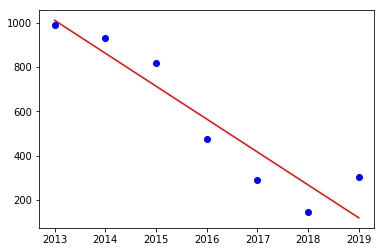

2


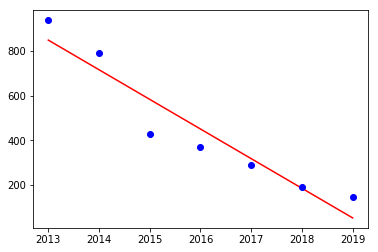

3


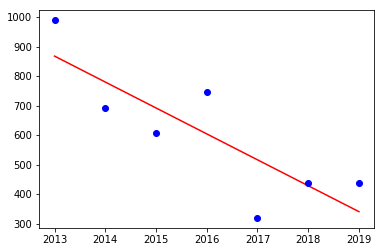

4


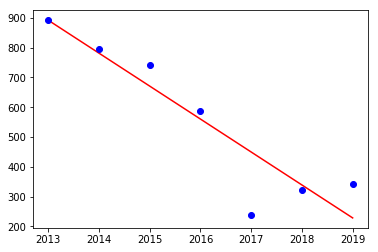

5


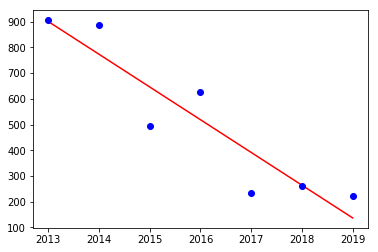

6


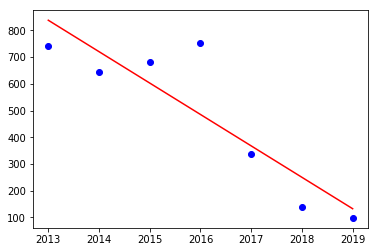

7


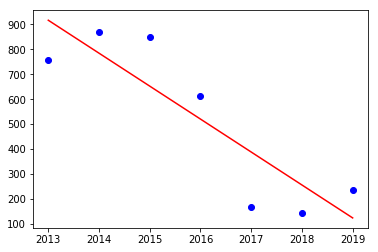

8


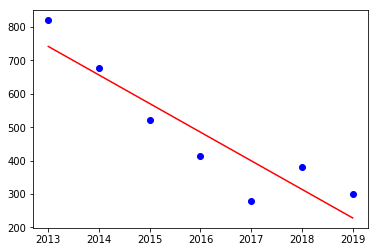

9


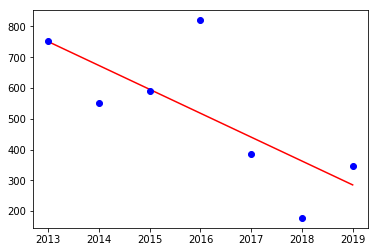

10


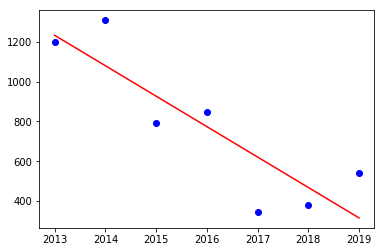

11


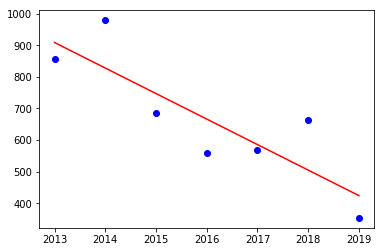

C:\Users\user\Anaconda2\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


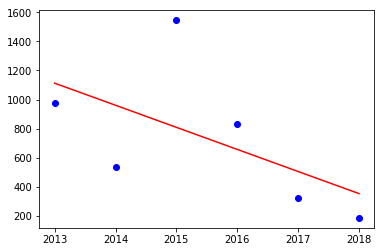

In [122]:
import statsmodels.api as sm
import sympy as sp
B0=list()
B1=list()
R2=list()
def regressionAnalysis(month) :
    
    Xt=np.transpose(X)[0]
    
    A=np.array([Xt,np.ones(len(Xt))])
    
    Yt=np.transpose(Y[month-1][0])[0]
    
    print month
    b0,b1=np.linalg.lstsq(A.T,Yt)[0]
    yhat=b0*Xt+b1
    B0.append(b0)
    B1.append(b1)
    plt.plot(Xt,yhat,'r-',Xt,Yt,'bo')
    plt.show()
    
    result = sm.OLS(Yt,A.T).fit()
    R2.append(result.rsquared)

for month in range(1,12): #11월까지 매년 순위변동추이
    regressionAnalysis(month)
    
#아직 차트가 존재하지 않는 2019년 12월
Xt=np.transpose(X)[0][:6]
A=np.array([Xt,np.ones(len(Xt))]).astype(np.float32)
Yt=np.transpose(Y[11][0])[0][:6].astype(np.float32)

b0,b1=np.linalg.lstsq(A.T,Yt)[0]
B0.append(b0)
B1.append(b1)
yhat=b0*Xt+b1
result = sm.OLS(Yt,A.T).fit()
R2.append(result.rsquared)
    
plt.plot(Xt,yhat,'r-',Xt,Yt,'bo')
plt.show()

----------

## 순위 예측

In [135]:
def predictRankVariation(year,month):
    rv=0
    rv=B0[month-1]*year+B1[month-1]
    
    print "순위 변동추이: {0}, Rsquared값: {1}".format(rv,"%.2f"%R2[month-1])

In [137]:
predictRankVariation(2019,12) #2019년 12월의 순위 변동추이는?
predictRankVariation(2020,10) #2020년 10월의 순위 변동추이는?
predictRankVariation(2020,1) #2020년 1월의 순위 변동추이는?

순위 변동추이: 202.339096069, Rsquared값: 0.33
순위 변동추이: 161.428571429, Rsquared값: 0.75
순위 변동추이: -30.9999999999, Rsquared값: 0.88
